# Testing fs8

In [1]:
Threads.nthreads()

1

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using GaussianProcess
using PythonCall
using NPZ
using BenchmarkTools;

In [3]:
np = pyimport("numpy");

In [4]:
meta = np.load("../data/DESY1/gcgc_gcwl_wlwl_meta.npz")
tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
pairs_ids = pyconvert(Vector{Vector{Int}}, meta["pairs_ids"])
idx = pyconvert(Vector{Int}, meta["idx"])
cls_data = pyconvert(Vector{Float64}, meta["cls"])
cls_cov = pyconvert(Matrix{Float64}, meta["cov"])
cls_inv_cov = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [5]:
files = npzread("../data/DESY1/gcgc_gcwl_wlwl_files.npz");

In [6]:
fs8_meta = npzread("../data/fs8s/fs8s.npz")
fs8_zs = fs8_meta["z"]
fs8_data = fs8_meta["data"]
fs8_cov = fs8_meta["cov"]

11×11 Matrix{Float64}:
 0.00203355   0.000811829  0.000264615  …  0.0     0.0     0.0       0.0
 0.000811829  0.00142289   0.000662824     0.0     0.0     0.0       0.0
 0.000264615  0.000662824  0.00118576      0.0     0.0     0.0       0.0
 0.0          0.0          0.0             0.0     0.0     0.0       0.0
 0.0          0.0          0.0             0.0     0.0     0.0       0.0
 0.0          0.0          0.0          …  0.0     0.0     0.0       0.0
 0.0          0.0          0.0             0.0     0.0     0.0       0.0
 0.0          0.0          0.0             0.0144  0.0     0.0       0.0
 0.0          0.0          0.0             0.0     0.0121  0.0       0.0
 0.0          0.0          0.0             0.0     0.0     0.003025  0.0
 0.0          0.0          0.0          …  0.0     0.0     0.0       0.013456

In [7]:
cov_tot = zeros(Float64, length(fs8_data)+length(cls_data), length(fs8_data)+length(cls_data))
cov_tot[1:length(fs8_data), 1:length(fs8_data)] = fs8_cov
cov_tot[length(fs8_data)+1:(length(fs8_data)+length(cls_data)),
        length(fs8_data)+1:(length(fs8_data)+length(cls_data))] = cls_cov
data_vector = [fs8_data ; cls_data];

In [8]:
fid_cosmo = Cosmology()
N = 100
latent_x = Vector(0:0.3:3)
x = Vector(range(0., stop=3., length=N));

In [9]:
pars = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
         1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
        -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
         2.389208e-01,   -6.435288e-01, 
         1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
        -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
         8.536883e-01,    2.535825e-01];

In [10]:
nuisances = Dict("DESgc__0_0_b" => pars[5],
                 "DESgc__1_0_b" => pars[6],
                 "DESgc__2_0_b" => pars[7],
                 "DESgc__3_0_b" => pars[8],
                 "DESgc__4_0_b" => pars[9],
                 "DESgc__0_0_dz" => pars[10],
                 "DESgc__1_0_dz" => pars[11],
                 "DESgc__2_0_dz" => pars[12],
                 "DESgc__3_0_dz" => pars[13],
                 "DESgc__4_0_dz" => pars[14],

                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16],

                 "DESwl__0_e_dz" => pars[21],
                 "DESwl__1_e_dz" => pars[22],
                 "DESwl__2_e_dz" => pars[23],
                 "DESwl__3_e_dz" => pars[24],
                 "DESwl__0_e_m" => pars[17],
                 "DESwl__1_e_m" => pars[18],
                 "DESwl__2_e_m" => pars[19],
                 "DESwl__3_e_m" => pars[20])

Dict{String, Float64} with 20 entries:
  "DESwl__2_e_dz" => -0.00109794
  "DESwl__3_e_m"  => -0.00111773
  "A_IA"          => 0.238921
  "DESwl__0_e_m"  => 0.00180272
  "DESwl__3_e_dz" => -0.00491232
  "DESgc__3_0_dz" => 0.00119705
  "DESgc__1_0_b"  => 1.63905
  "DESgc__2_0_b"  => 1.59717
  "DESwl__1_e_dz" => 0.00677778
  "DESwl__1_e_m"  => -0.00550899
  "DESgc__4_0_dz" => -0.0051998
  "DESgc__3_0_b"  => 1.94458
  "DESwl__2_e_m"  => 0.0195251
  "DESgc__1_0_dz" => -0.00284
  "DESgc__0_0_dz" => -0.00467938
  "DESgc__4_0_b"  => 2.00725
  "alpha_IA"      => -0.643529
  "DESgc__0_0_b"  => 1.34389
  "DESwl__0_e_dz" => -0.0174408
  "DESgc__2_0_dz" => 0.00177157

In [11]:
eta = 0.005
l = 1.0

latent_N = length(latent_x)
v = ones(latent_N)

mu = fid_cosmo.Dz(vec(latent_x))
K = sqexp_cov_fn(latent_x; eta=eta, l=l)
latent_gp = latent_GP(mu, v, K)
gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                  eta=eta, l=l)

dmu =  growth_rate(fid_cosmo, vec(latent_x)) ./ (1 .+ latent_x)
dK = sqexp_cov_grad(latent_x; eta=eta, l=l)
latent_dgp = latent_GP(dmu, v, dK)
dgp = conditional(latent_x, x, latent_dgp, sqexp_cov_grad;
                  eta=eta, l=l)

100-element Vector{Float64}:
 -0.37520931339393193
 -0.38214476960332877
 -0.3881218179419595
 -0.39315299946329535
 -0.39725561919324903
 -0.40045151947547747
 -0.40276682079908505
 -0.404231632892621
 -0.40487973915587505
 -0.4047482577533817
 -0.4038772829076117
 -0.4023095101028354
 -0.40008984904059053
  ⋮
 -0.19726343362698034
 -0.19452171228849435
 -0.1914531322413253
 -0.18803986145238644
 -0.1842651251342578
 -0.1801133997626434
 -0.17557060358015353
 -0.1706242812194781
 -0.16526378012599233
 -0.15948041653742695
 -0.15326762888494844
 -0.14662111661417915

In [12]:
using Plots

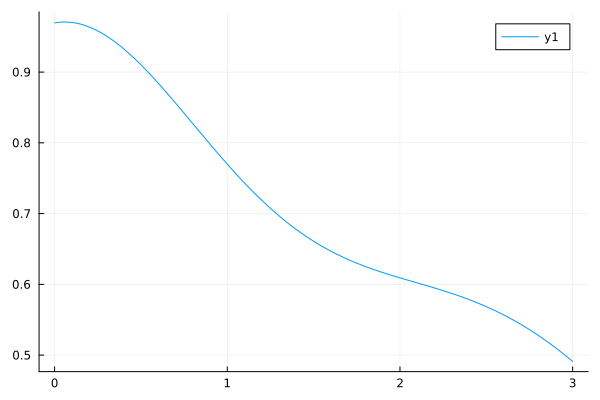

In [13]:
#plot(latent_x, latent_gp)
plot(x, gp)

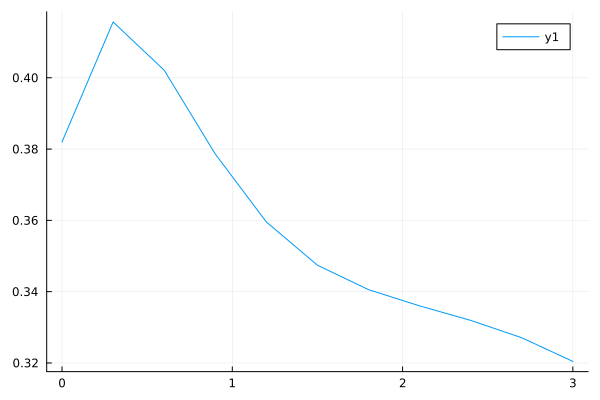

In [14]:
plot(latent_x, -0.811 .* latent_gp .* (1 .+ latent_x) .* latent_dgp)

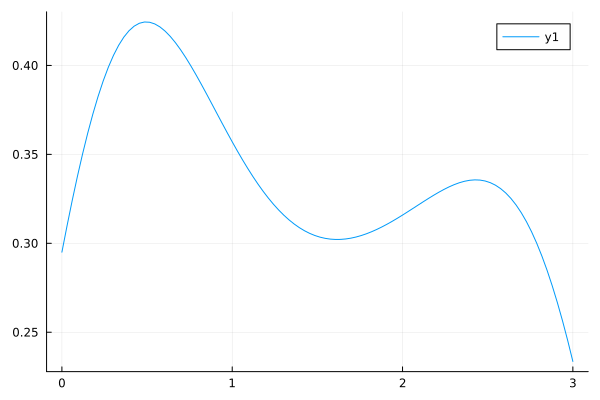

In [15]:
plot(x, -0.811 .* gp .* (1 .+ x) .* dgp)

## Sample Prior

In [17]:
function make_theory(Ωm;
                      tracers_names=tracers_names,
                      pairs=pairs,
                      idx=idx,
                      cov_tot=cov_tot, 
                      files=files,
                      fid_cosmo=fid_cosmo,
                      latent_x=latent_x,
                      x=x)
    

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = 0.811

    eta = 0.01
    l = 1.0

    latent_N = length(latent_x)
    v = ones(latent_N)
    
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=eta, l=l)
    latent_gp = latent_GP(mu, v, K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=eta, l=l)

    dmu =  growth_rate(fid_cosmo, vec(latent_x)) ./ (1 .+ latent_x)
    dK = sqexp_cov_grad(latent_x; eta=eta, l=l)
    latent_dgp = latent_GP(dmu, v, dK)
    dgp = conditional(latent_x, x, latent_dgp, sqexp_cov_grad;
                      eta=eta, l=l)
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit";
                                     custom_Dz=[x, gp, dgp])
    
    cls = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    fs8s = -0.811 .* gp .* (1 .+ x) .* dgp
    
    return latent_gp, fs8s, cls
end;

In [ ]:
N_samples = 1000
cls_preds = zeros(N_samples, length(cls_data))
gps_preds = zeros(N_samples, length(latent_x))
fs8s_preds = zeros(N_samples, length(x))
for i in 1:N_samples
    Ωm = rand(Uniform(0.1, 0.6))
    gps_preds[i,:], fs8s_preds[i,:], cls_preds[i,:] = make_theory(Ωm)
end

In [ ]:
cls_preds_m, cls_preds_s = mean(cls_preds, dims=1), std(cls_preds, dims=1);
fs8s_preds_m, fs8s_preds_s = mean(fs8s_preds, dims=1), std(fs8s_preds, dims=1);
gps_preds_m, gps_preds_s = mean(gps_preds, dims=1), std(gps_preds, dims=1);

In [ ]:
npzwrite("fs8_ploting.npz", Dict("cls_m" => cls_preds_m,
                                 "cls_s" => cls_preds_s, 
                                 "fs8s_m" => fs8s_preds_m,
                                 "fs8s_s" => fs8s_preds_s,
                                 "gps_m" => gps_preds_m,
                                 "gps_s" => gps_preds_s)) 

## Sample Posterior

In [ ]:
@model function model(data_vector;
                      tracers_names=tracers_names,
                      pairs=pairs,
                      idx=idx,
                      cov_tot=cov_tot, 
                      files=files,
                      fid_cosmo=fid_cosmo,
                      latent_x=latent_x,
                      x=x)
    
    Ωm ~ Uniform(0.1, 0.9)
    Ωb ~ Uniform(0.03, 0.07)
    h ~ Uniform(0.55, 0.91)
    ns ~ Uniform(0.87, 1.07)
    s8 = 0.811
    
    DESgc__0_0_b ~ Uniform(0.8, 3.0)
    DESgc__1_0_b ~ Uniform(0.8, 3.0)
    DESgc__2_0_b ~ Uniform(0.8, 3.0)
    DESgc__3_0_b ~ Uniform(0.8, 3.0)
    DESgc__4_0_b ~ Uniform(0.8, 3.0)
    DESgc__0_0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__1_0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__2_0_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DESgc__3_0_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESgc__4_0_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)
    DESwl__0_e_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    DESwl__1_e_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    DESwl__2_e_dz ~ TruncatedNormal(-0.009, 0.011, -0.2, 0.2)
    DESwl__3_e_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    DESwl__0_e_m ~ Normal(0.012, 0.023)
    DESwl__1_e_m ~ Normal(0.012, 0.023)
    DESwl__2_e_m ~ Normal(0.012, 0.023)
    DESwl__3_e_m ~ Normal(0.012, 0.023)

    nuisances = Dict("DESgc__0_0_b" => DESgc__0_0_b,
                 "DESgc__1_0_b" => DESgc__1_0_b,
                 "DESgc__2_0_b" => DESgc__2_0_b,
                 "DESgc__3_0_b" => DESgc__3_0_b,
                 "DESgc__4_0_b" => DESgc__4_0_b,
                 "DESgc__0_0_dz" => DESgc__0_0_dz,
                 "DESgc__1_0_dz" => DESgc__1_0_dz,
                 "DESgc__2_0_dz" => DESgc__2_0_dz,
                 "DESgc__3_0_dz" => DESgc__3_0_dz,
                 "DESgc__4_0_dz" => DESgc__4_0_dz,

                 "A_IA" => A_IA,
                 "alpha_IA" => alpha_IA,

                 "DESwl__0_e_dz" => DESwl__0_e_dz,
                 "DESwl__1_e_dz" => DESwl__1_e_dz,
                 "DESwl__2_e_dz" => DESwl__2_e_dz,
                 "DESwl__3_e_dz" => DESwl__3_e_dz,
                 "DESwl__0_e_m" => DESwl__0_e_m,
                 "DESwl__1_e_m" => DESwl__1_e_m,
                 "DESwl__2_e_m" => DESwl__2_e_m,
                 "DESwl__3_e_m" => DESwl__3_e_m)

    eta = 0.2
    l = 0.3

    latent_N = length(latent_x)
    v ~ filldist(truncated(Normal(0, 1), -3, 3), latent_N)
    
    mu = fid_cosmo.Dz(vec(latent_x))
    K = sqexp_cov_fn(latent_x; eta=eta, l=l)
    dmu = fid_cosmo.fs8z(vec(latent_x))
    dK = sqexp_cov_grad(latent_x; eta=eta, l=l)
    latent_gp = latent_GP(mu, v, K)
    latent_dgp = latent_GP(dmu, v, dK)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                      eta=eta, l=l)
    dgp = conditional(latent_x, x, latent_dgp, sqexp_cov_grad;
                      eta=eta, l=l)
    
    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit", 
                          custom_Dz=[x, gp, dgp])
    
    cls = Theory(cosmology, files;
                 Nuisances=nuisances,
                 nz_path=nz_path)
    
    fs8s = fs8(z_fs8)
    theory = [cls; fs8s]
    
    data_vector ~ MvNormal(theory, cov_tot)
    return(gp=gp, theory=theory)
end;

In [ ]:
cycles = 10
iterations = 50
TAP = 0.60
adaptation = 10
#nchains = Threads.nthreads()


# Start sampling.
folpath = "../chains"
folname = string("DES_test_gp_", "TAP", TAP)
folname = joinpath(folpath, folname)

mkdir(folname)
println("Created new folder")

for i in 1:cycles
    if i == 1
        chain = sample(model(data_vector), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true)
    else
        old_chain = read(joinpath(folname, string("chain_", i-1, ".jls")), Chains)
        chain = sample(model(data_vector), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true,
                       resume_from=old_chain)
    end 
    write(joinpath(folname, string("chain_", i,".jls")), chain)
    CSV.write(joinpath(folname, string("chain_", i,".csv")), chain)
end